Author: Jonathan Gong

In [1]:
import pandas as pd
import os
import sys
import sktime
from sktime.annotation.hmm_learn import GMMHMM 
import numpy as np

# Data processing

In [2]:
csv_files = []
for file in os.listdir('../data/raw'):
    if file.endswith('.csv'):
        csv_files.append(pd.read_csv(f'../data/raw/{file}'))

C:\Users\Nathan\AppData\Local\Temp\ipykernel_7520\895166927.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_files.append(pd.read_csv(f'../data/raw/{file}'))


In [3]:
each_bgl =[]
for file in csv_files:
    each_df = file[["date", "bgl", "msg_type"]]
    each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
    each_df.dropna(subset=['date'], inplace = True)
    each_df.dropna(subset=["bgl"], inplace = True)
    each_df["msg_type"] = [
    1 if i == 'ANNOUNCE_EXERCISE' else 2 if i == 'ANNOUNCE_MEAL' else 0
    for i in each_df["msg_type"]
    ]
    each_df.sort_values('date', inplace = True)
    each_df.drop_duplicates(subset=['date'], inplace = True)
    # each_df.set_index('date', inplace=True)
    each_bgl.append(each_df)

C:\Users\Nathan\AppData\Local\Temp\ipykernel_7520\2187542184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
C:\Users\Nathan\AppData\Local\Temp\ipykernel_7520\2187542184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df.dropna(subset=['date'], inplace = True)
C:\Users\Nathan\AppData\Local\Temp\ipykernel_7520\2187542184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

In [4]:
print(each_bgl[1])

                           date    bgl  msg_type
0     2024-07-01 04:02:32+00:00  115.0         0
1     2024-07-01 04:05:33+00:00  112.0         0
2     2024-07-01 04:08:33+00:00  116.0         0
3     2024-07-01 04:10:34+00:00  121.0         0
4     2024-07-01 04:13:36+00:00  122.0         0
...                         ...    ...       ...
40101 2024-10-01 03:43:17+00:00  108.0         0
40102 2024-10-01 03:47:20+00:00  101.0         0
40103 2024-10-01 03:50:22+00:00   96.0         0
40104 2024-10-01 03:54:25+00:00  103.0         0
40105 2024-10-01 03:57:26+00:00  103.0         0

[39091 rows x 3 columns]


In [5]:
days_patients = []
for bgl in each_bgl:
    # (hour:minute:second)
    bgl['time'] = bgl['date'].dt.time
    # (year-month-day)
    bgl['day'] = bgl['date'].dt.date
    # unique days
    unique_days = bgl['day'].unique()
    day_data = []
    for i, day in enumerate(unique_days):
        bgl_day = bgl[bgl['day'] == day]
        day_data.append(bgl_day[["date", "bgl"]])

    days_patients.append(day_data)

C:\Users\Nathan\AppData\Local\Temp\ipykernel_7520\1387374491.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bgl['time'] = bgl['date'].dt.time
C:\Users\Nathan\AppData\Local\Temp\ipykernel_7520\1387374491.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bgl['day'] = bgl['date'].dt.date
C:\Users\Nathan\AppData\Local\Temp\ipykernel_7520\1387374491.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [6]:
for patient_days in days_patients:
    for df in patient_days:
        df.set_index('date', inplace=True)

In [7]:
all_days_patient_0 = pd.concat(days_patients[0])
all_days_patient_1 = pd.concat(days_patients[1])

In [8]:
Y_0 = each_bgl[0][["msg_type"]]
Y_1 = each_bgl[1][["msg_type"]]

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_days_patient_0)

In [10]:
# all_days_patient_0.to_csv(os.path.expanduser('~/Downloads/all_days_patient_0.csv'))

In [11]:
from sklearn.cluster import KMeans
data_used = all_days_patient_0

n_components = 2 # Number of components in the GMMHMM
kmeans = KMeans(n_clusters=n_components).fit(data_used)
initial_means = kmeans.cluster_centers_

In [12]:
initial_means

array([[158.95139039],
       [ 94.94794851]])

# Model training and eval

In [13]:
def runGMMHMM(supervised, X, n_components, n_mix, n_iter, Y = "bruh"):
    if not supervised:
        model = GMMHMM(n_components=n_components, n_mix=n_mix, n_iter=n_iter, covariance_type = 'full',  verbose = True)
        model.startprob_ = np.array([0.5, 0.5])
        model.means_ = initial_means
        model.fit(X)
        return model
    else:
        model = GMMHMM(n_mix=n_mix, n_iter=n_iter, covariance_type = 'full', verbose=True)
        model.startprob_ = np.array([0.5, 0.5])
        model.means_ = initial_means
        print("supervised")
        model.fit_predict(X = X, Y = Y)
        return model

In [36]:
from scipy.ndimage import gaussian_filter1d

# Apply Gaussian smoothing
X_smoothed = gaussian_filter1d(all_days_patient_0['bgl'], sigma=15)

n_components = 2
model = runGMMHMM(supervised=False, n_components=n_components, X=X_smoothed.reshape(-1, 1), n_mix=2, n_iter=100)


         1 -174454.67815172             +nan
         2 -155654.52070308  +18800.15744864
         3 -153227.91046190   +2426.61024118
         4 -151405.57009718   +1822.34036472
         5 -147145.70643844   +4259.86365873
         6 -139818.24014519   +7327.46629325
         7 -135640.87549333   +4177.36465187
         8 -134985.83332170    +655.04217162
         9 -134755.64602715    +230.18729455
        10 -134663.01378221     +92.63224494
        11 -134619.21176722     +43.80201499
        12 -134591.24638268     +27.96538454
        13 -134569.88403492     +21.36234776
        14 -134552.57774482     +17.30629010
        15 -134538.20455149     +14.37319332
        16 -134525.91036810     +12.29418339
        17 -134514.84689838     +11.06346972
        18 -134504.27522813     +10.57167025
        19 -134493.93022192     +10.34500621
        20 -134483.85134614     +10.07887578
        21 -134474.09288279      +9.75846335
        22 -134464.92221471      +9.17066808
        23

In [49]:
test_data = pd.concat(days_patients[0][0:7])
test_smoothed = gaussian_filter1d(test_data['bgl'], sigma=15)

hidden_states = model.predict(test_smoothed.reshape(-1, 1))


In [52]:
np.unique(hidden_states) #im gna kill myself please for the love of god be smth different

array([0, 1], dtype=int64)

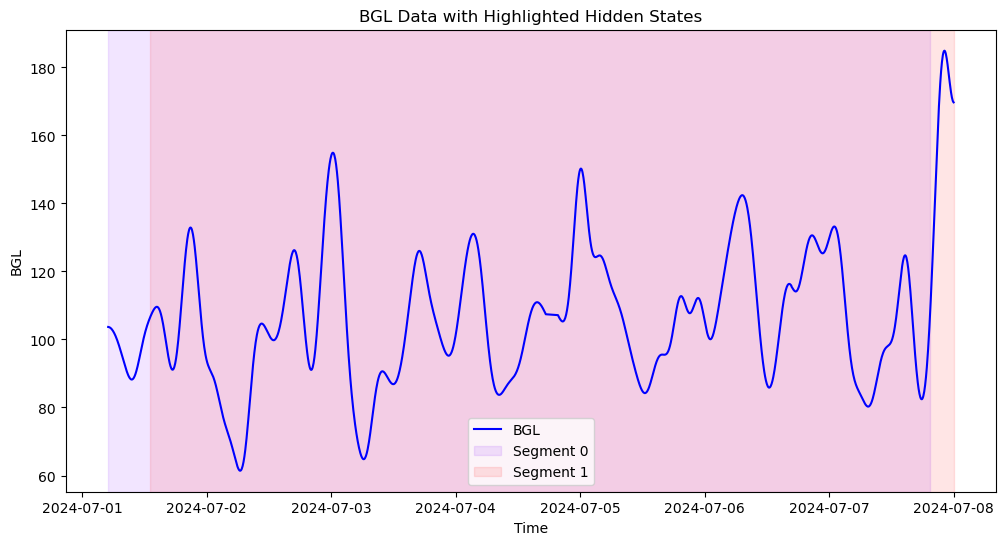

In [51]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Convert numpy array back to DataFrame
bruh = pd.DataFrame(test_smoothed, index=test_data.index, columns=['bgl'])

# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
unique_segments = np.unique(hidden_states)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    masks = hidden_states == segment
    segment_indices = bruh.index[masks] 
    plt.axvspan(segment_indices.min(), segment_indices.max(),
                alpha=0.1, color=color, label=f'Segment {segment}')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()

In [18]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto', sparse_output=False)
Y_0 = encoder.fit_transform(Y_0)

In [19]:
n_components = 4
model = runGMMHMM(supervised= True, n_components=n_components, X = all_days_patient_0, n_mix = 16, n_iter = 100, Y = Y_0)

supervised


         1 -171218.95037991             +nan
         2 -160150.66424246  +11068.28613745
         3 -159471.50703840    +679.15720406
         4 -159317.00587918    +154.50115922
         5 -159244.45886877     +72.54701041
         6 -159197.39857737     +47.06029140
         7 -159160.62156115     +36.77701622
         8 -159128.82072976     +31.80083139
         9 -159099.84242041     +28.97830935
        10 -159072.68794447     +27.15447594
        11 -159046.85026424     +25.83768023
        12 -159022.07445777     +24.77580647
        13 -158998.25852010     +23.81593766
        14 -158975.40254180     +22.85597831
        15 -158953.57536519     +21.82717661
        16 -158932.88791922     +20.68744597
        17 -158913.46962081     +19.41829841
        18 -158895.44715644     +18.02246437
        19 -158878.92624748     +16.52090896
        20 -158863.97747880     +14.94876869
        21 -158850.62720876     +13.35027004
        22 -158838.85412503     +11.77308373
        23

In [20]:
hidden_states = model.predict(pd.concat(days_patients[0][0:7]))

In [21]:
np.unique(hidden_states)

array([0], dtype=int64)

1930


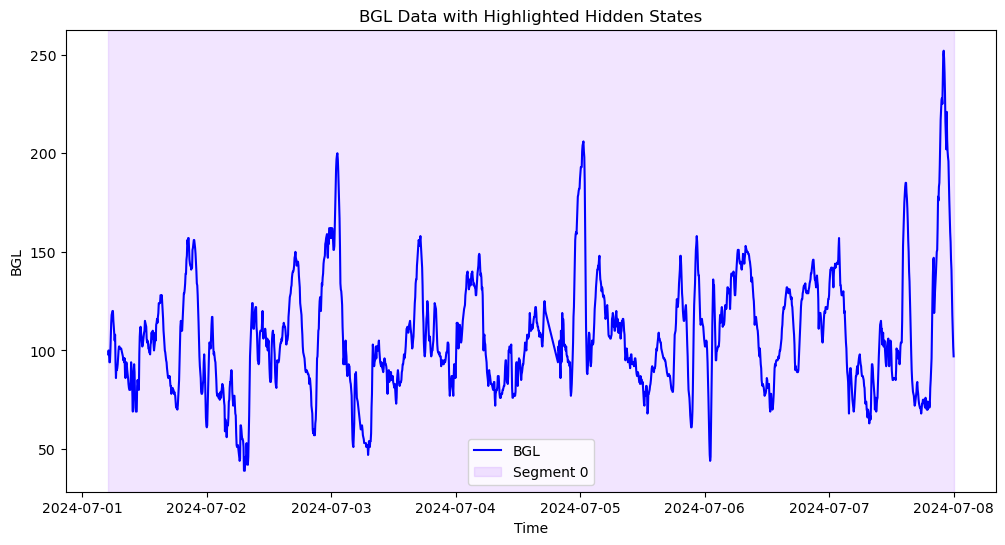

In [22]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))


bruh = pd.concat(days_patients[0][0:7])
# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
unique_segments = np.unique(hidden_states)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    masks = hidden_states == segment
    print(len(masks))
    segment_indices = bruh.index[masks] 
    plt.axvspan(segment_indices.min(), segment_indices.max(),
                alpha=0.1, color=color, label=f'Segment {segment}')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()